<a href="https://colab.research.google.com/github/PranatSiyal/ML-SurfaceEC-NN/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN for previous code

*   p = 0.1
*   round - 2






 images processed: 12500000 and epoch 50


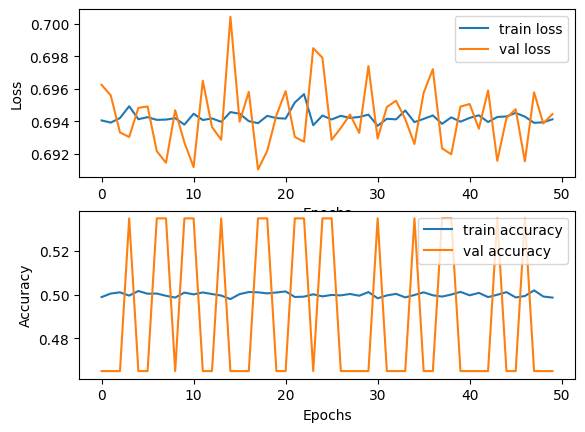

In [ ]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch
import stim

def createcircuit(code_size, rounds, clifford_noise=0.0, reset_flip_prob=0.0, measure_flip_prob=0.0, round_data_noise=0.0):
    circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds, distance=code_size,
            after_clifford_depolarization=clifford_noise,
            after_reset_flip_probability=reset_flip_prob,
            before_measure_flip_probability=measure_flip_prob,
            before_round_data_depolarization=round_data_noise)
    return circuit


def customreshape(samplelist, code_size):
    M = code_size+1
    images = []
    for vlist in samplelist:
        t = np.zeros((M,M), dtype=np.float32)
        t[0,1:-1:2] = vlist[0:int((code_size-1)/2)]
        k = 1
        l = 1
        st = int((code_size-1)/2)
        for i in range(code_size-1):
            t[l,k:k+code_size] = vlist[st:st+code_size]
            st = st+code_size
            if l%2 == 1:
                k = 0
            else:
                k = 1
            l += 1
        t[M-1,2:-1:2] = vlist[st:]
        images.append(t)
    return images

def sampledata(circuit, code_size, numsnaps, rounds):
    sampler = circuit.compile_detector_sampler()
    snapshots = []
    labels = []
    num_x_stabilizers = (int(code_size/2)+1)*(code_size-1)
    num_z_stabilizers = num_x_stabilizers
    num_stabilizers = num_x_stabilizers + num_z_stabilizers
    start = num_z_stabilizers + (rounds-2)*num_stabilizers
    res = numsnaps
    while len(snapshots) < numsnaps:
        lsamples, obs = sampler.sample(shots=res, separate_observables=True)
        lsamples = lsamples[:, start:start+num_stabilizers]
        non_empty_indices = (np.sum(lsamples, axis=1)!=0)
        reshapedsnapshots = customreshape(lsamples[non_empty_indices, :].tolist(), code_size)
        snapshots.extend(reshapedsnapshots)
        labels.extend(obs[non_empty_indices, :].astype(np.uint8))
        res = numsnaps - len(snapshots)
    return [np.stack(snapshots, axis=0), np.stack(labels, axis=0)]

class CustomTensorDataset(Dataset):
    def __init__(self, dataset, transform_list=None):
        [data_X, data_y] = dataset
        X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
        tensors = (X_tensor, y_tensor)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transforms:
            x = self.transforms(x)
        y = self.tensors[1][index]
        return torch.unsqueeze(x, 0), y.float()

    def __len__(self):
        return self.tensors[0].size(0)

class Netconv5RNN(nn.Module):
    def __init__(self, rnn_layers=4):
        super(Netconv5RNN, self).__init__()
        self.rnn_layers = rnn_layers

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)

        # RNN layers
        self.rnn = nn.RNN(input_size=16, hidden_size=16, num_layers=self.rnn_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, height, -1)

        # RNN layers
        h0 = torch.zeros(self.rnn_layers, x.size(0), 16).to(x.device)
        x, _ = self.rnn(x, h0)

        # Reshape back
        x = x[:, -1, :]

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

class Netconv5(nn.Module):
    def __init__(self):
        super(Netconv5, self).__init__()
        #self.conv1 = nn.Conv2d(1, 24, 3)
        #self.mpool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(24, 24, 3)
        #self.fc1 = nn.Linear(10*5*5, 512)
        ##self.fc2 = nn.Linear(20, 10)
        #self.fc2 = nn.Linear(512,1)

        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)
        #self.mpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        #x = torch.relu(self.conv1(x))
        ##x = self.mpool(x)
        #x = torch.relu(self.conv2(x))
        ##print(x.shape)
        ##x = self.mpool(x)
        #x = x.view(-1, 10*5*5)
        ##x = torch.relu(self.fc1(x))
        ##x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc1(x))
        #x = self.fc2(x)
        #x = torch.sigmoid(x)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        #x = self.mpool(x)
        x = x.view(-1, 16)
        x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

def trainmodel(model, trainloader, testloader, optimizer, criterion, numepochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    num = 0
    num_images = 0
    epochelapsed = 0
    for epoch in range(numepochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += ((outputs>0.5) == labels).sum().item()
            num_images += labels.size(0)
            print("\r images processed: {} and epoch {}".format(num_images, epoch+1), end='')
        train_loss /= len(trainloader)
        train_loss_history.append(train_loss)
        train_acc /= len(trainloader.dataset)
        train_acc_history.append(train_acc)

        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += ((outputs > 0.5) == labels).sum().item()
        val_loss /= len(testloader)
        val_loss_history.append(val_loss)
        val_acc /= len(testloader.dataset)
        val_acc_history.append(val_acc)

    print("")
    return [train_loss_history, train_acc_history, val_loss_history, val_acc_history]


if __name__ == '__main__':

    # device = "cpu"
    epochs = 50
    p = 0.1
    ckt = createcircuit(5, 2,  measure_flip_prob=p, round_data_noise=p)
    testset = CustomTensorDataset(dataset=sampledata(ckt, 5, 10000, 2))
    p = 0.4
    ckt = createcircuit(5, 2,  measure_flip_prob=p, round_data_noise=p)
    trainset = CustomTensorDataset(dataset=sampledata(ckt, 5, 250000, 2))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
    net = Netconv5RNN()
    criterion = nn.BCELoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-4)
    [y1, y2, y3, y4] = trainmodel(net, trainloader, testloader, optimizer, \
                            criterion, epochs)
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(y1, label='train loss')
    axes[0].plot(y3, label='val loss')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(y2, label='train accuracy')
    axes[1].plot(y4, label='val accuracy')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

In [1]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch
import stim

def createcircuit(code_size, rounds, clifford_noise=0.0, reset_flip_prob=0.0, measure_flip_prob=0.0, round_data_noise=0.0):
    circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds, distance=code_size,
            after_clifford_depolarization=clifford_noise,
            after_reset_flip_probability=reset_flip_prob,
            before_measure_flip_probability=measure_flip_prob,
            before_round_data_depolarization=round_data_noise)
    return circuit


def customreshape(samplelist, code_size):
    M = code_size+1
    images = []
    for vlist in samplelist:
        t = np.zeros((M,M), dtype=np.float32)
        t[0,1:-1:2] = vlist[0:int((code_size-1)/2)]
        k = 1
        l = 1
        st = int((code_size-1)/2)
        for i in range(code_size-1):
            t[l,k:k+code_size] = vlist[st:st+code_size]
            st = st+code_size
            if l%2 == 1:
                k = 0
            else:
                k = 1
            l += 1
        t[M-1,2:-1:2] = vlist[st:]
        images.append(t)
    return images

def sampledata(circuit, code_size, numsnaps, rounds):
    sampler = circuit.compile_detector_sampler()
    snapshots = []
    labels = []
    num_x_stabilizers = (int(code_size/2)+1)*(code_size-1)
    num_z_stabilizers = num_x_stabilizers
    num_stabilizers = num_x_stabilizers + num_z_stabilizers
    start = num_z_stabilizers + (rounds-2)*num_stabilizers
    res = numsnaps
    while len(snapshots) < numsnaps:
        lsamples, obs = sampler.sample(shots=res, separate_observables=True)
        lsamples = lsamples[:, start:start+num_stabilizers]
        non_empty_indices = (np.sum(lsamples, axis=1)!=0)
        reshapedsnapshots = customreshape(lsamples[non_empty_indices, :].tolist(), code_size)
        snapshots.extend(reshapedsnapshots)
        labels.extend(obs[non_empty_indices, :].astype(np.uint8))
        res = numsnaps - len(snapshots)
    return [np.stack(snapshots, axis=0), np.stack(labels, axis=0)]

class CustomTensorDataset(Dataset):
    def __init__(self, dataset, transform_list=None):
        [data_X, data_y] = dataset
        X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
        tensors = (X_tensor, y_tensor)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transforms:
            x = self.transforms(x)
        y = self.tensors[1][index]
        return torch.unsqueeze(x, 0), y.float()

    def __len__(self):
        return self.tensors[0].size(0)

class Netconv5RNN(nn.Module):
    def __init__(self, rnn_layers=4):
        super(Netconv5RNN, self).__init__()
        self.rnn_layers = rnn_layers

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)

        # RNN layers
        self.rnn = nn.RNN(input_size=16, hidden_size=16, num_layers=self.rnn_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, height, -1)

        # RNN layers
        h0 = torch.zeros(self.rnn_layers, x.size(0), 16).to(x.device)
        x, _ = self.rnn(x, h0)

        # Reshape back
        x = x[:, -1, :]

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

class Netconv5(nn.Module):
    def __init__(self):
        super(Netconv5, self).__init__()
        #self.conv1 = nn.Conv2d(1, 24, 3)
        #self.mpool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(24, 24, 3)
        #self.fc1 = nn.Linear(10*5*5, 512)
        ##self.fc2 = nn.Linear(20, 10)
        #self.fc2 = nn.Linear(512,1)

        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)
        #self.mpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        #x = torch.relu(self.conv1(x))
        ##x = self.mpool(x)
        #x = torch.relu(self.conv2(x))
        ##print(x.shape)
        ##x = self.mpool(x)
        #x = x.view(-1, 10*5*5)
        ##x = torch.relu(self.fc1(x))
        ##x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc1(x))
        #x = self.fc2(x)
        #x = torch.sigmoid(x)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        #x = self.mpool(x)
        x = x.view(-1, 16)
        x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

def trainmodel(model, trainloader, testloader, optimizer, criterion, numepochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    num = 0
    num_images = 0
    epochelapsed = 0
    for epoch in range(numepochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += ((outputs>0.5) == labels).sum().item()
            num_images += labels.size(0)
            print("\r images processed: {} and epoch {}".format(num_images, epoch+1), end='')
        train_loss /= len(trainloader)
        train_loss_history.append(train_loss)
        train_acc /= len(trainloader.dataset)
        train_acc_history.append(train_acc)

        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += ((outputs > 0.5) == labels).sum().item()
        val_loss /= len(testloader)
        val_loss_history.append(val_loss)
        val_acc /= len(testloader.dataset)
        val_acc_history.append(val_acc)

    print("")
    return [train_loss_history, train_acc_history, val_loss_history, val_acc_history]


if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 50
    p = 0.2
    ckt = createcircuit(5, 4,  measure_flip_prob=p, round_data_noise=p)
    testset = CustomTensorDataset(dataset=sampledata(ckt, 5, 10000, 4))

    ckt = createcircuit(5, 4,  measure_flip_prob=p, round_data_noise=p)
    trainset = CustomTensorDataset(dataset=sampledata(ckt, 5, 250000, 4))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
    net = Netconv5RNN()
    net.to(device)
    criterion = nn.BCELoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    [y1, y2, y3, y4] = trainmodel(net, trainloader, testloader, optimizer, \
                            criterion, epochs)
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(y1, label='train loss')
    axes[0].plot(y3, label='val loss')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(y2, label='train accuracy')
    axes[1].plot(y4, label='val accuracy')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

ModuleNotFoundError: ignored

In [2]:
!pip3 install stim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.7 MB/s eta 0:00:00


RNN for new code
p = 0.1
round - 10

 images processed: 36452980 and epoch 50


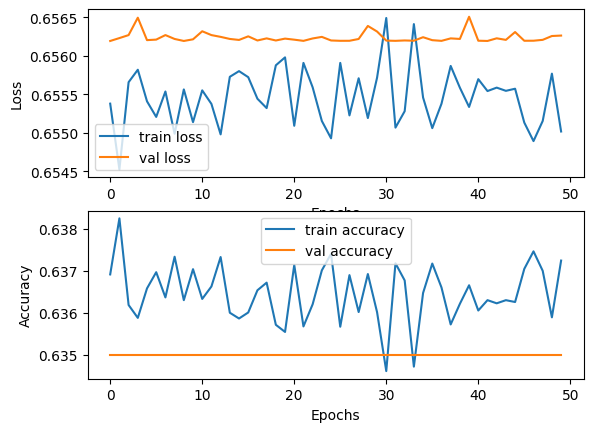

In [5]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch
import stim

def createcircuit(code_size, rounds, clifford_noise=0.0, reset_flip_prob=0.0, measure_flip_prob=0.0, round_data_noise=0.0):
    circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds, distance=code_size,
            after_clifford_depolarization=clifford_noise,
            after_reset_flip_probability=reset_flip_prob,
            before_measure_flip_probability=measure_flip_prob,
            before_round_data_depolarization=round_data_noise)
    return circuit


def customreshape(samplelist, code_size):
    M = code_size+1
    images = []
    for vlist in samplelist:
        t = np.zeros((M,M), dtype=np.float32)
        t[0,1:-1:2] = vlist[0:int((code_size-1)/2)]
        k = 1
        l = 1
        st = int((code_size-1)/2)
        for i in range(code_size-1):
            t[l,k:k+code_size] = vlist[st:st+code_size]
            st = st+code_size
            if l%2 == 1:
                k = 0
            else:
                k = 1
            l += 1
        t[M-1,2:-1:2] = vlist[st:]
        images.append(t)
    return images

def sampledata(circuit, code_size, numsnaps, rounds):
    sampler = circuit.compile_detector_sampler()
    snapshots = []
    labels = []
    num_x_stabilizers = (int(code_size/2)+1)*(code_size-1)
    num_z_stabilizers = num_x_stabilizers
    num_stabilizers = num_x_stabilizers + num_z_stabilizers
    start = num_z_stabilizers + (rounds-2)*num_stabilizers
    res = numsnaps
    for i in range(2):
        snapshots_one_class = []
        labels_one_class = []
        while len(snapshots_one_class) < numsnaps/2:
            lsamples, obs = sampler.sample(shots=res, separate_observables=True)
            lsamples = lsamples[np.where(obs==i)[0]]
            obs = obs[np.where(obs==i)[0]]
            if lsamples.shape[0] < 1:
                continue
            lsamples = lsamples[:, start:start+num_stabilizers]
            non_empty_indices = (np.sum(lsamples, axis=1)!=0)
            reshapedsnapshots = customreshape(lsamples[non_empty_indices, :].tolist(), code_size)
            snapshots_one_class.extend(reshapedsnapshots)
            labels_one_class.extend(obs[non_empty_indices, :].astype(np.uint8))
            res = numsnaps - len(snapshots)
        snapshots.extend(snapshots_one_class)
        labels.extend(labels_one_class)
    X = np.stack(snapshots, axis=0)
    y =  np.stack(labels, axis=0)
    perm = np.random.permutation(X.shape[0])
    return [X[perm], y[perm]]

class CustomTensorDataset(Dataset):
    def __init__(self, dataset, transform_list=None):
        [data_X, data_y] = dataset
        X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
        tensors = (X_tensor, y_tensor)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transforms:
            x = self.transforms(x)
        y = self.tensors[1][index]
        return torch.unsqueeze(x, 0), y.float()

    def __len__(self):
        return self.tensors[0].size(0)

class Netconv5(nn.Module):
    def __init__(self):
        super(Netconv5, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)
        #self.mpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x


class Netconv5RNN(nn.Module):
    def __init__(self, rnn_layers=4):
        super(Netconv5RNN, self).__init__()
        self.rnn_layers = rnn_layers

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.conv2 = nn.Conv2d(24, 24, 3)
        self.conv3 = nn.Conv2d(24, 16, 2)

        # RNN layers
        self.rnn = nn.RNN(input_size=16, hidden_size=16, num_layers=self.rnn_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, height, -1)

        # RNN layers
        h0 = torch.zeros(self.rnn_layers, x.size(0), 16).to(x.device)
        x, _ = self.rnn(x, h0)

        # Reshape back
        x = x[:, -1, :]

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x



def trainmodel(model, ckt, testloader, optimizer, criterion, numepochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    num = 0
    num_images = 0
    epochelapsed = 0
    for epoch in range(numepochs):
        trainset = CustomTensorDataset(dataset=sampledata(ckt, 5, 500000, 10))
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += ((outputs>0.5) == labels).sum().item()
            num_images += labels.size(0)
            print("\r images processed: {} and epoch {}".format(num_images, epoch+1), end='')
        train_loss /= len(trainloader)
        train_loss_history.append(train_loss)
        train_acc /= len(trainloader.dataset)
        train_acc_history.append(train_acc)

        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += ((outputs > 0.5) == labels).sum().item()
        val_loss /= len(testloader)
        val_loss_history.append(val_loss)
        val_acc /= len(testloader.dataset)
        val_acc_history.append(val_acc)

    print("")
    return [train_loss_history, train_acc_history, val_loss_history, val_acc_history]


if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 50
    p = 0.1
    ckt = createcircuit(5, 10, round_data_noise=p)
    testset = CustomTensorDataset(dataset=sampledata(ckt, 5, 10000, 10))
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
    net = Netconv5RNN()
    criterion = nn.BCELoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    [y1, y2, y3, y4] = trainmodel(net, ckt, testloader, optimizer, \
                            criterion, epochs)
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].plot(y1, label='train loss')
    axes[0].plot(y3, label='val loss')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(y2, label='train accuracy')
    axes[1].plot(y4, label='val accuracy')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()